# Development of miscellaneous new features for polymerist

## Testing polymerist importability within environment

In [ ]:
import polymerist as ps

print(ps.__version__)
print(ps.pascal(5))

In [ ]:
from polymerist.mdtools import openfftools

openfftools.POLYMERIST_TOOLKIT_REGISTRY.registered_toolkits

In [ ]:
import polymerist as ps
from polymerist.genutils.importutils import pyimports, module_hierarchy

print(module_hierarchy(ps))

In [ ]:
import nglview

print(nglview.__version__)
nglview.demo()

In [ ]:
from polymerist.polymers.monomers import specification
from rdkit import Chem

smi = 'CCO-c1ccccc1-N=C=C'
mol1 = Chem.MolFromSmiles(smi)
display(mol1)

sma = specification.expanded_SMILES(smi, assign_map_nums=True)
exp_sma = specification.compliant_mol_SMARTS(sma)
mol2 = Chem.MolFromSmarts(sma)
display(mol2)


In [ ]:
import numpy as np
import pandas as pd

from openff.toolkit import Molecule, Topology, ForceField

offmol = Molecule.from_smiles(smi)
offmol.generate_conformers(n_conformers=1)
offmol.visualize(backend='nglview')

## Experimenting with Protocols

In [ ]:
from typing import Protocol, runtime_checkable
from dataclasses import dataclass


@runtime_checkable
class Nominative(Protocol):
    def name(self) -> str:
        ...
        
class Foo(Nominative):
    def __init__(self, letter : str):
        self.letter = letter
        
    def name(self) -> str:
        return self.letter*3

@dataclass
class Bar:
    id : int
    
    def name(self) -> str:
        return f'{type(self).__name__}{self.id}'
    
@dataclass
class Baz:
    id : int
    
    def nombre(self) -> str:
        return 'name'

In [ ]:
classes = (Foo, Bar, Baz)
a = Foo('a')
b = Bar(2)
c = Baz(3)
instances = (a, b, c)

In [ ]:
for typ in classes:
    print(typ, issubclass(typ, Nominative))

In [ ]:
for inst in instances:
    print(inst, isinstance(inst, Nominative))

# Development for reactions

In [1]:
from polymerist.smileslib import expanded_SMILES
from polymerist.rdutils.reactions.reactions import AnnotatedReaction
from polymerist.rdutils import rdkdraw

rdkdraw.disable_substruct_highlights()

from rdkit import Chem


def sanitized_mol_with_aromaticity(smiles : str, arom_model : Chem.AromaticityModel=Chem.AROMATICITY_MDL) -> Chem.Mol:
    exp_smiles = expanded_SMILES(smiles, assign_map_nums=False)
    mol = Chem.MolFromSmiles(exp_smiles, sanitize=False)
    Chem.SanitizeMol(mol)
    Chem.Kekulize(mol, clearAromaticFlags=True)
    Chem.SetAromaticity(mol, model=arom_model)
    
    return mol

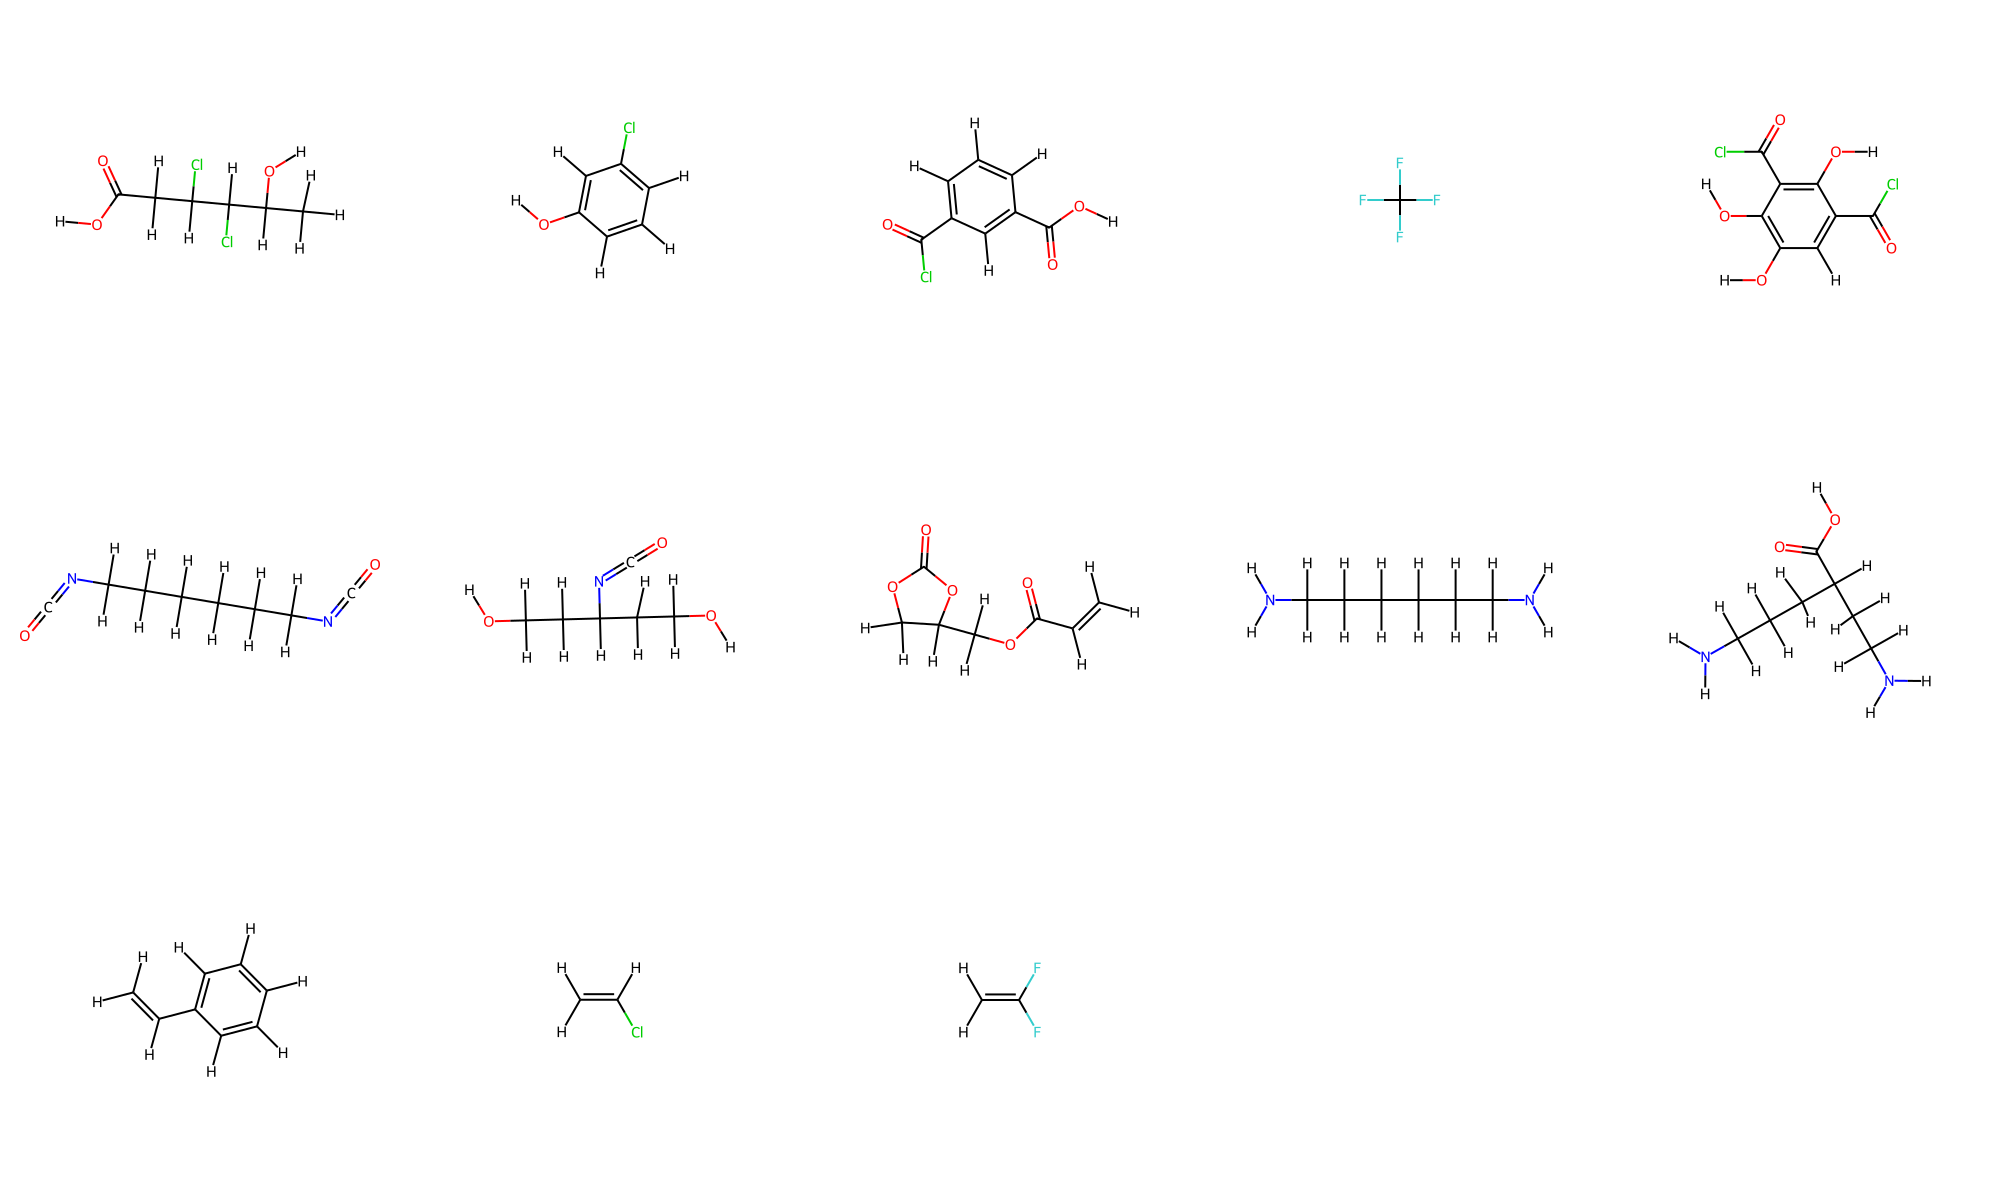

In [10]:
from rdkit.Chem.Draw import MolsToGridImage

# DEFINING REACTANTS
reactant_smiles = [ 
    'CC(O)C(Cl)C(Cl)CC(=O)O',
    'c1ccc(Cl)cc1O',
    'c1ccc(C(=O)Cl)cc1C(=O)O',
    'FC(F)(F)F',
    'c1(O)c(O)c(C(=O)Cl)c(O)c(C(=O)Cl)c1',
    "O=C=N\\CCCCCC/N=C=O",
    "OCCC(N=C=O)CCO",
    'C=CC(=O)OCC1COC(=O)O1',
    'NCCCCCCN',
    'NCCC(C(=O)O)CCCN',
    'C=Cc1ccccc1',
    'C=C(Cl)',
    'FC(F)=C',
]
reactants = [
    sanitized_mol_with_aromaticity(smiles)
        for smiles in reactant_smiles
]

N = 400
display(MolsToGridImage(reactants, molsPerRow=5, subImgSize=(N, N)))

# DEFINING REACTIONS
RXN_SMARTS : dict[str, str] = {
    'polyamide'     : '[#7:1](-[*:2])(-[#1])-[#1:3].[#8](-[#6:4](=[#8:5])-[*:6])-[#1]>>[#7:1](-[*:2])(-[#1:3])-[#6:4](=[#8:5])-[*:6]',
    'polyvinyl'     : '[*:1]-[#6:2](-[*:3])=[#6:4](-[#1:5])-[#1:6].[*:7]-[#6:8](=[#6:9](-[#1:10])-[#1:11])-[#1:12]>>[*:1]-[#6:2](-[*:3])(-[#6:4](-[#1:5])(-[#1:6])-[#6:8](-[*:7])=[#6:9](-[#1:10])-[#1:11])-[#1:12]',
    'polycarbonate' : '[#1]-[#8:1]-[!$([#6]=[#8]):2].[#17]-[#6:3](=[#8:4])-[*:5]>>[#8:1](-[!$([#6]=[#8]):2])-[#6:3](=[#8:4])-[*:5]',
    'polyurethane_isocyanate': '[#1:1]-[#8:2]-[!$([#6]=[#8]):3].[#8:4]=[#6:5]=[#7:6]-[*:7]>>[#1:1]-[#7:6](-[#6:5](-[#8:2]-[!$([#6]=[#8]):3])=[#8:4])-[*:7]',
    "polyurethane_nonisocyanate": "[*:1]-[#6:2]1(-[#1:3])-[#8:4]-[#6:5](=[#8:6])-[#8:7]-[#6:8]-1(-[*:9])-[#1:10].[#7:11](-[*:12])(-[#1:13])-[#1:14]>>[*:1]-[#6:2](-[#1:3])(-[#8:4]-[#1:13])-[#6:8](-[#8:7]-[#6:5](=[#8:6])-[#7:11](-[*:12])-[#1:14])(-[*:9])-[#1:10]",
    # NOTE: have deliberately excluded compatible reactants for polyimides to test whether negative results are correctly returned during reactant perception
    'polyimide' : '[#7:1](-[*:2])(-[#1])-[#1].[*:3]-[#6:4](=[#8:5])-[#8]-[#6:6](=[#8:7])-[*:8]>>[#7:1](-[*:2])(-[#6:4](-[*:3])=[#8:5])-[#6:6](=[#8:7])-[*:8]',
}
RXNS : dict[str, AnnotatedReaction] = {}
for rxn_name, rxn_smarts in RXN_SMARTS.items():
    rxn = AnnotatedReaction.from_smarts(rxn_smarts)
    rxn.Initialize()
    # display(rxn)
    RXNS[rxn_name] = rxn

## Testing that reactant pathfinding for AnnotatedReaction works as intended

In [ ]:
from itertools import combinations
from polymerist.rdutils.reactions.reactors import Reactor

rxn = RXNS['polyimide']
reactor = Reactor(rxn)
for i, rs in enumerate(combinations(reactants, 2)):
    print(f'PAIR {i+1}')
    (react1, react2) = rs
    reactant_order = rxn.valid_reactant_ordering(rs)
    if reactant_order is None:
        print('NO ORDER FOUND:')
    else:
        print('ORDER FOUND:')
        print('+'*50)
        for m in reactant_order:
            display(m)
            
        display(reactor.react(rs)[0])

    print('='*50)

adducts:


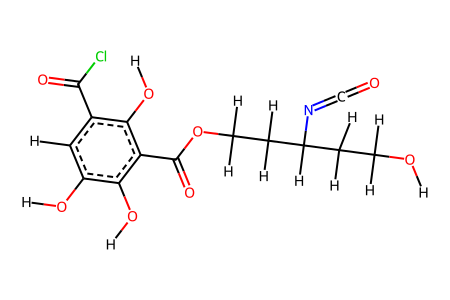

fragments:


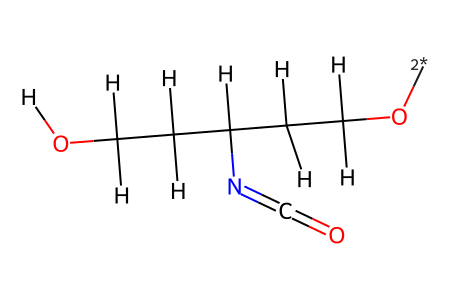

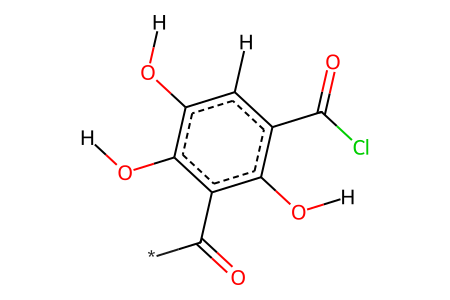

adducts:


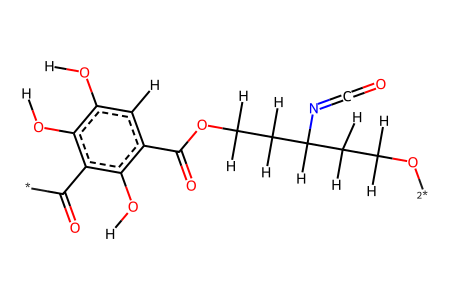

fragments:


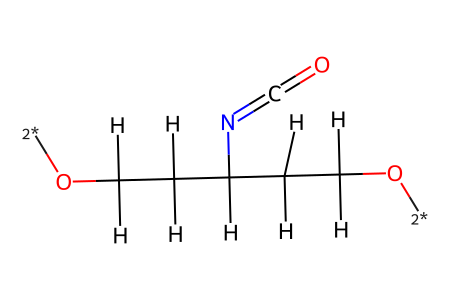

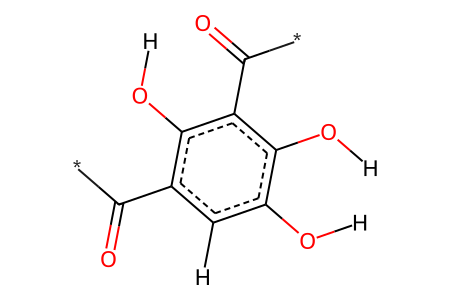

In [13]:
from polymerist.rdutils.reactions.reactors import Reactor, PolymerizationReactor

rxn = RXNS['polyamide']
rxn = RXNS['polycarbonate']
reactor = PolymerizationReactor(rxn)
rs = rxn.valid_reactant_ordering([reactants[4], reactants[6]], allow_resampling=False)
for adducts, frags in reactor.propagate(rs, clear_map_nums=True):
    print('adducts:')
    for adduct in adducts:
        display(adduct)
        
    print('fragments:')
    for frag in frags:
        display(frag)
        
    print('='*50)

## Simplifying bookkeeping for reacting atom/bond tracking

In [ ]:
rxn = RXNS['polyamide']
rxn = RXNS['polyimide']
rxn = RXNS['polyurethane_nonisocyanate']
rxn = RXNS['polyurethane_isocyanate']
display(rxn)

for change_type, binfos in rxn.mapped_bond_info_by_change_type.items():
    print(change_type)
    for binfo in binfos:
        print(binfo)

In [ ]:
from polymerist.rdutils.reactions.reactors import PolymerizationReactor

rs = rxn.valid_reactant_ordering(reactants)
assert rs is not None

reactor = PolymerizationReactor(rxn)
product = reactor.react(rs, keep_map_labels=False)[0]
display(product)

In [ ]:
reac = PolymerizationReactor(rxn)


rs = rxn.valid_reactant_ordering(reactants)
for i, mol in enumerate(rs):
    for atom in mol.GetAtoms():
        atom.SetIntProp('foo',i)

product = reac.react(rs)[0]
for atom in product.GetAtoms():
    print(atom.GetPropsAsDict())

#### Testing polyimides (multi-bond cycles)

In [ ]:
from polymerist.rdutils.reactions.reactors import PolymerizationReactor

smis = [
    'O(c1ccc(N)cc1)c2ccc(cc2)N',
    'C1=C2C(=CC3=C1C(=O)OC3=O)C(=O)OC2=O'
]

reactants = []
for smi in smis:
    mol = sanitized_mol_with_aromaticity(smi, arom_model=Chem.AROMATICITY_MDL)
    # mol = sanitized_mol_with_aromaticity(smi, arom_model=Chem.AROMATICITY_RDKIT)
    display(mol)
    reactants.append(mol)
    
rxn = RXNS['polyimide']
reactor = PolymerizationReactor(rxn)
product = reactor.react(reactants)[0]
display(product)

In [ ]:
reactor = PolymerizationReactor(rxn)
for adducts, frags in reactor.propagate(reactants):
    print('adducts:')
    for adduct in adducts:
        display(adduct)
        
    print('fragments:')
    for frag in frags:
        display(frag)

# Developing enhanced IBIS with weighted bond conditions

In [ ]:
import networkx as nx
from polymerist.rdutils.chemselect import (
    AtomCondition,
    BondCondition,
    bond_condition_by_atom_condition_factory,
    bonds_by_condition,
    atoms_by_condition,
    logical_and,
)


bond_between_mapped_atoms : BondCondition = bond_condition_by_atom_condition_factory(lambda atom : atom.GetAtomMapNum() != 0, binary_operator=logical_and)

idxs = bonds_by_condition(product, condition=bond_between_mapped_atoms, negate=False)
G = nx.Graph(idxs)

w0 = G.number_of_edges()
nx.set_edge_attributes(G, w0, name='capacity')
G[0][2]['capacity'] -= 0.5
G[5][7]['capacity'] -= 0.5

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edge_labels(G, pos, nx.get_edge_attributes(G, 'capacity'))

In [ ]:
bond_ids = bonds_by_condition(product, condition=bond_between_mapped_atoms, negate=False, as_indices=True, as_pairs=False)
submol = Chem.PathToSubmol(product, list(bond_ids))

In [ ]:
from typing import ClassVar, Generator

import networkx as nx

from polymerist.rdutils.bonding.portlib import is_linker
from polymerist.rdutils.rdgraphs import rdmol_to_networkx
from polymerist.rdutils.reactions.fragment import IBIS, bridgehead_atom_ids
from polymerist.rdutils.reactions.reactions import RxnProductInfo


class CutBridgesOrNewBonds(IBIS):
    '''
    IBIS which cleaves bonds in the following descending order of preference:
    -- New bonds between R-group atoms which are also bridge bonds
    -- Bonds which are bridges only
    -- Bonds which are new only
    -- Random choice, if none of the above are present 
    ''' # DEVNOTE: the "random choice" default is not currently implemented
    CUT_COST_KW : ClassVar[str] = 'capacity' # name of edge attribute which stores the cost of each edge being cut
    MAX_BONDS_PER_CUT : ClassVar[int] = 1 # greatest number of bonds allowed to be broken per cut

    # 0) set weights for network flow optimization problem
    BASE_EDGE_CUT_COST : ClassVar[float] = 2.0
    BRIDGE_DISCOUNT    : ClassVar[float] = 0.5 
    NEW_BOND_DISCOUNT  : ClassVar[float] = 0.25
    NON_RGROUP_BOND_DISCOUNT   : ClassVar[float] = 0.125

    assert BASE_EDGE_CUT_COST > (BRIDGE_DISCOUNT + NEW_BOND_DISCOUNT) # all weights must remain positive even after the maximum possible deduction
    assert BRIDGE_DISCOUNT > NEW_BOND_DISCOUNT # force bridge bonds to be given priority over new bonds in the even of a tie
    
    def locate_intermonomer_bonds(self, product: Chem.Mol, product_info : RxnProductInfo) -> Generator[int, None, None]:
        # 1) initialize molecular graph
        rdgraph = rdmol_to_networkx(product) # DEVNOTE: the properties required here could be significantly relaxed
        
        ## 1a) extract subgraph for atoms active in reaction (simplifies computation) 
        ## This implicitly disallows ring cutting for intra-molecular reactions
        mapped_linker_atom_ids = []
        mapped_atom_ids = []
        for atom in product.GetAtoms():   # NOTE: assumes reacting atoms are mapped while the rest are not;
            if atom.GetAtomMapNum() != 0: # may revisit this assumption in the future if it becomes brittle
                atom_idx = atom.GetIdx()
                mapped_atom_ids.append(atom_idx)
                if is_linker(atom):
                    mapped_linker_atom_ids.append(atom_idx)
        active_subgraph = rdgraph.subgraph(mapped_atom_ids)

        ## 1b) Set costs for cutting bonds
        nx.set_edge_attributes(active_subgraph, self.BASE_EDGE_CUT_COST - self.NON_RGROUP_BOND_DISCOUNT, name=self.CUT_COST_KW) # pre-discount for R-groups
        ### apply discount for bridges
        for (atom_idx_begin, atom_idx_end) in nx.bridges(active_subgraph):
            active_subgraph[atom_idx_begin][atom_idx_end][self.CUT_COST_KW] -= self.BRIDGE_DISCOUNT
            
        ### apply discount for newly-formed bonds
        for template_bond_id, bond_atom_maps_nums in product_info.new_bond_ids_to_map_nums.items():
            atom_idx_begin, atom_idx_end = atom_ids_by_map_nums(product, *bond_atom_maps_nums) # deprecate, can read this off directly based on bond info
            active_subgraph[atom_idx_begin][atom_idx_end][self.CUT_COST_KW] -= self.NEW_BOND_DISCOUNT
            
        ### remove discount for all bonds connected to linkers (R-group bonds)
        for linker_idx in mapped_linker_atom_ids:
            for neighbor in product.GetAtomWithIdx(linker_idx).GetNeighbors():
                active_subgraph[linker_idx][neighbor.GetIdx()][self.CUT_COST_KW] += self.NON_RGROUP_BOND_DISCOUNT
            
        # 2) identify minimal cut-sets between all pairs of R-group bridgeheads
        bonds_already_cut : set[int] = set()
        for bh_atom_pair in combinations(bridgehead_atom_ids(product), 2):
            try:
                flow_across_cut, (source_part, sink_part) = nx.minimum_cut(active_subgraph, *bh_atom_pair, capacity=self.CUT_COST_KW)
            except nx.NetworkXUnbounded:
                continue
            else:
                cut_edges = nx.edge_boundary(active_subgraph, source_part, sink_part)
                if (num_bonds_cut := len(cut_edges)) > self.MAX_BONDS_PER_CUT:
                    continue
                
                for edge_nodes in cut_edges:
                    edge_idx = product.GetBondBetweenAtoms(*edge_nodes).GetIdx()
                    if edge_idx in bonds_already_cut:
                        continue
                        
                    yield edge_idx
                    bonds_already_cut.add(edge_idx)

# Another thing